In [ ]:
import importlib
import pickle
# import risk_instruments
import pandas as pd
import numpy as np
import os
import sys
import pandas as pd
import plotly.io as pio
import seaborn as sns
import plotly.graph_objects as go


# from risk_instruments.database import DBconnect
# from risk_instruments.universal_analysis import woe_stab, woe_line
# from risk_instruments.express_analysis import gain_chart
# from configures import user, password
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.pipeline import Pipeline
from IPython.core.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats.distributions import chi2
from matplotlib import pyplot as plt
from lightgbm import LGBMClassifier, plot_importance
from scipy.stats import bernoulli, norm
from plotly.subplots import make_subplots
import lightgbm as lgb

# importlib.reload(risk_instruments.database)
pio.renderers.default='notebook'
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
# перекинул данные модели из прошлой дз(передал обученный бустинг, так как качество у него было лучше)
import joblib
bust_model = joblib.load('/content/sample_data/model.pkl')

In [ ]:
path = '/content/sample_data/data_scores_and_features-0667850d-f03d-4d60-9ffc-93cb745050b4.csv'
df = pd.read_csv(path)

In [ ]:
df.head()

,user_id,pd,x_score,max_util,avg_util,credits_2y,credits_4y,bad_history_credits_flg,other_util,avg_term,min_term,avg_limit_mortgage,min_limit_mfo,close_balance_amt,soc_dem_score,max_delq_cnt,avg_active_time,last_credit_time_years
0,5269,"0,0390977205391442","0,127199135674353",0.000000,0.000000,0.0,0.0,1,0.210959,-7.111111,-57.0,-1.0,-1.0,0.0,-5.834056,0.0,-1.0,0.0
1,157747,"0,00298839119397661","0,624327037460113",0.000000,0.000000,0.0,0.0,1,0.200141,190.714286,5.0,3545000.0,-1.0,39646.0,-7.996644,0.0,170.0,0.0
2,112119,"0,0634189586034202","0,166025075663731",0.906661,0.777738,0.0,0.0,1,0.887264,19.000000,16.0,-1.0,-1.0,9087.0,-4.420416,0.0,21.0,1.0
3,131663,"0,0538517590370807","0,097733043837605",1.003618,0.381491,1.0,1.0,1,0.371895,138.500000,12.0,-1.0,-1.0,1262802.0,-6.395523,0.0,60.0,2.0
4,122778,"0,0462823278081679","0,458679924133087",0.900334,0.347921,0.0,0.0,0,0.366521,8.200000,3.0,-1.0,-1.0,10801.0,-6.920208,0.0,16.0,2.0


In [ ]:
features = list(df.columns)
features

['user_id',
 'pd',
 'x_score',
 'max_util',
 'avg_util',
 'credits_2y',
 'credits_4y',
 'bad_history_credits_flg',
 'other_util',
 'avg_term',
 'min_term',
 'avg_limit_mortgage',
 'min_limit_mfo',
 'close_balance_amt',
 'soc_dem_score',
 'max_delq_cnt',
 'avg_active_time',
 'last_credit_time_years']

In [ ]:
# Препроцессинг
features.remove('user_id')
features.remove('pd')
features.remove('x_score')

# корреляты 
features.remove('avg_util')
features.remove('credits_2y')
features.remove('min_term')

# слабые фияи по ROC-AUC

features.remove('avg_active_time')
features.remove('avg_term')
features.remove('bad_history_credits_flg')
features.remove('max_delq_cnt')

In [ ]:
df[features]

,max_util,credits_4y,other_util,avg_limit_mortgage,min_limit_mfo,close_balance_amt,soc_dem_score,last_credit_time_years
0,0.000000,0.0,0.210959,-1.0,-1.0,0.0,-5.834056,0.0
1,0.000000,0.0,0.200141,3545000.0,-1.0,39646.0,-7.996644,0.0
2,0.906661,0.0,0.887264,-1.0,-1.0,9087.0,-4.420416,1.0
3,1.003618,1.0,0.371895,-1.0,-1.0,1262802.0,-6.395523,2.0
4,0.900334,0.0,0.366521,-1.0,-1.0,10801.0,-6.920208,2.0
...,...,...,...,...,...,...,...,...
104815,0.964679,1.0,0.274023,-1.0,-1.0,482463.0,-5.870624,3.0
104816,1.024933,1.0,0.936263,-1.0,-1.0,216829.0,-5.389767,0.0
104817,0.804570,0.0,0.275365,-1.0,29400.0,1593051.0,-6.395103,1.0
104818,0.933907,0.0,0.343365,-1.0,-1.0,324267.0,-6.146846,1.0


In [ ]:
new_pd = bust_model.predict_proba(df[features])[:, 1]

In [ ]:
new_pd

array([0.0600106 , 0.03228317, 0.08920206, ..., 0.03754534, 0.07456798,
       0.0395323 ])

In [ ]:
# обновил значения столбца pd своими значениями, не меняя x_score
df['x_score'] = [x.replace(',', '.') for x in df['x_score']]
df['x_score'] = df['x_score'].astype(float)


df_scores = pd.DataFrame({'user_id': df['user_id'], 'pd': new_pd, 'x_score': df['x_score']})
df_scores

,user_id,pd,x_score
0,5269,0.060011,0.127199
1,157747,0.032283,0.624327
2,112119,0.089202,0.166025
3,131663,0.087466,0.097733
4,122778,0.073016,0.458680
...,...,...,...
104815,39195,0.090711,0.361921
104816,113647,0.109657,0.196731
104817,158552,0.037545,0.222133
104818,35628,0.074568,0.247079


In [ ]:
# скачал два датасета винтажей и объединил в один
vintage1 = pd.read_csv('/content/sample_data/data_vintages1-b183c416-d3e2-482a-9dab-20f0191e7ed5.csv')
vintage2 = pd.read_csv('/content/sample_data/data_vintages2-545c8f7a-aa95-4479-9dfa-34a514871c53.csv')

data_vintages = pd.concat([vintage1, vintage2], ignore_index=True)
data_vintages.head()

,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg
0,127336,19,2019-07-01,2019-07-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,35907,16,2019-04-01,2019-04-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,45228,21,2019-05-01,2019-04-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,39035,23,2019-07-01,2019-07-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,130780,19,2019-08-01,2019-07-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
df_scores = df_scores.sort_values(['pd'], ignore_index=True)
df_scores['pd_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['pd_bucket'])['pd'].mean())

df_scores = df_scores.sort_values(['x_score'], ignore_index=True)
df_scores['x_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['x_bucket'])['x_score'].mean())

data_vintages = data_vintages.merge(df_scores[['user_id', 'pd_bucket', 'x_bucket', 'pd', 'x_score']], how='left', on='user_id').dropna()
data_vintages.head()

pd_bucket
0    0.030679
1    0.056036
2    0.098704
Name: pd, dtype: float64
x_bucket
0    0.133270
1    0.220838
2    0.379452
Name: x_score, dtype: float64


,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg,pd_bucket,x_bucket,pd,x_score
0,127336,19,2019-07-01,2019-07-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2,2,0.098166,0.469410
1,35907,16,2019-04-01,2019-04-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0.051080,0.157215
2,45228,21,2019-05-01,2019-04-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,2,0.056664,0.469583
3,39035,23,2019-07-01,2019-07-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0.033426,0.210896
4,130780,19,2019-08-01,2019-07-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0.039842,0.269492


In [ ]:
default_ratio_data = (data_vintages.groupby(["gen_quarter_dt", "statement_num"])     # группировка по поколению и месяцу жизни клиента
        .agg({"def_flg":np.mean})                                         # считаем средний уровень дефолта
        .rename(columns = {"def_flg": 'default_ratio'})                   # переименовываем столбец со средними значениями
        .unstack('gen_quarter_dt'))                                       # разворачиваем таблицу, столбцы теперь поколения
default_ratio_data

default_ratio                                            
gen_quarter_dt    2019-01-01 2019-04-01 2019-07-01 2019-10-01 2020-01-01
statement_num                                                           
1                   0.000000   0.000000   0.000000   0.000000   0.000000
2                   0.000000   0.000000   0.000000   0.000000   0.000000
3                   0.000000   0.000000   0.000000   0.000000   0.000000
4                   0.025039   0.024008   0.022657   0.021524   0.021375
5                   0.030704   0.029233   0.027301   0.024900   0.025176
6                   0.034677   0.034623   0.031013   0.030460   0.030152
7                   0.043792   0.041452   0.037671   0.034824   0.035385
8                   0.048765   0.046340   0.042553   0.040071   0.039306
9                   0.054160   0.052608   0.047404   0.044346   0.043408
10                  0.059950   0.058198   0.052300   0.048337   0.048428
11                  0.067106   0.063605   0.059115   0.051993   0.053317
12                  0.070590   0.070169   0.066038   0.054430   0.059025
13                  0.075687   0.075865   0.071803   0.058694   0.063436
14                  0.082691   0.085023   0.075577   0.062849   0.068363
15                  0.088743   0.089898   0.079344   0.067798   0.071649
16                  0.093584   0.094475   0.084090   0.071277   0.074722
17                  0.101224   0.099083   0.087772   0.074803   0.078443
18                  0.105411   0.104700   0.091413   0.077510   0.079935
19                  0.108954   0.107283   0.097290   0.079515   0.082402
20                  0.113934   0.113264   0.099196   0.082210   0.085150
21                  0.118999   0.117209   0.102759   0.084621   0.087956
22                  0.122854   0.121724   0.105714   0.085489   0.089194
23                  0.125918   0.125691   0.108107   0.087071   0.091320
24                  0.130934   0.128197   0.112668   0.087097   0.092118

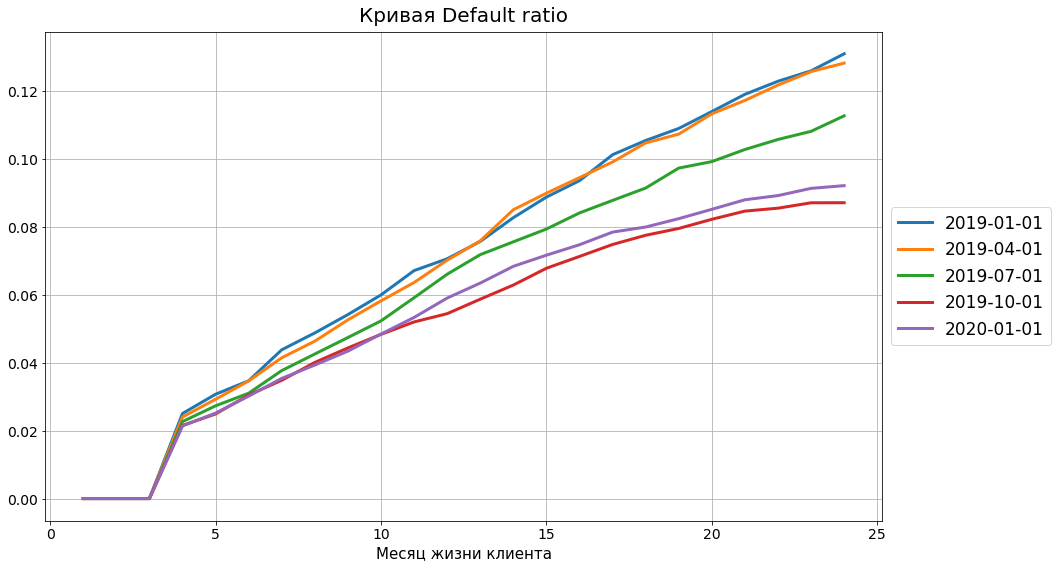

In [ ]:
# функция с семинара 
def plot_default_ratio_by_generation(df):
    return (data_vintages.groupby(["gen_quarter_dt", "statement_num"])
            .agg({"def_flg":np.mean})
            .rename(columns = {"def_flg": 'default_ratio'})
            .unstack('gen_quarter_dt')
            ['default_ratio']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))               

# Строим график при помощи pyplot
plot_default_ratio_by_generation(data_vintages)

# Настраиваем параметры отображения графика
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Default ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

In [ ]:
def plot_default_ratio_by_bucket(df, bucket):
    return (data_vintages.query(''' gen_quarter_dt == '2019-01-01' ''')
            .groupby([bucket, "statement_num"])
            .agg({"def_flg":np.mean})
            .rename(columns = {"def_flg": 'default_ratio'})
            .unstack(bucket)
            ['default_ratio']
            .plot(ax=None, figsize=(10, 6), grid=True, lw = 3))

plot_default_ratio_by_bucket(data_vintages, 'pd_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Default ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

KeyError: ignored

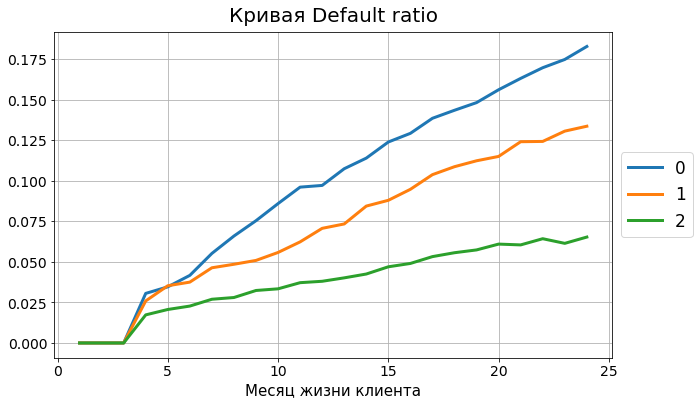

In [ ]:
plot_default_ratio_by_bucket(data_vintages, 'x_bucket')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Default ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Кажется, что разделение по pd выглядит немного лучше(разница медду значением нижней и верхней чуть больше)






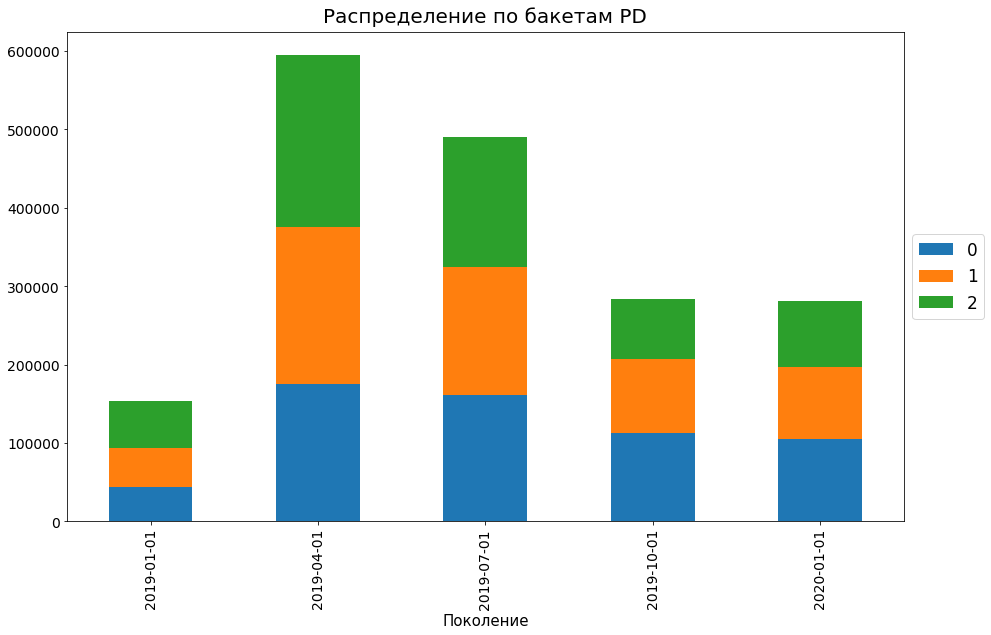

In [ ]:
def plot_distribution(df, bucket):
    return pd.pivot_table(data_vintages, index=[bucket], columns='gen_quarter_dt',          # делаем сводную таблицу и транспонируем ее
                values="user_id",
                aggfunc=np.count_nonzero, fill_value=0)\
               .T\
               .plot(kind='bar', stacked=True, figsize=(15, 9))                    # Рисуем график распределения столбиками

plot_distribution(data_vintages, 'pd_bucket')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Распределение по бакетам PD", size=20, verticalalignment='bottom')
plt.xlabel("Поколение", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Кол-во данных в первом бакете в целом достаточно велико для того, чтобы его не удалть. Поэтому я решил его оставить. 

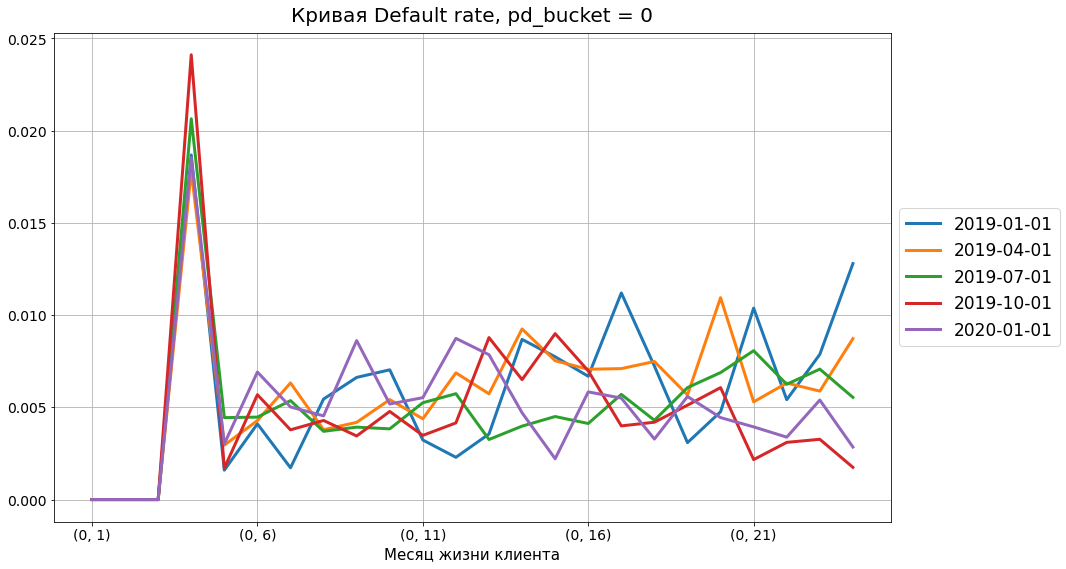

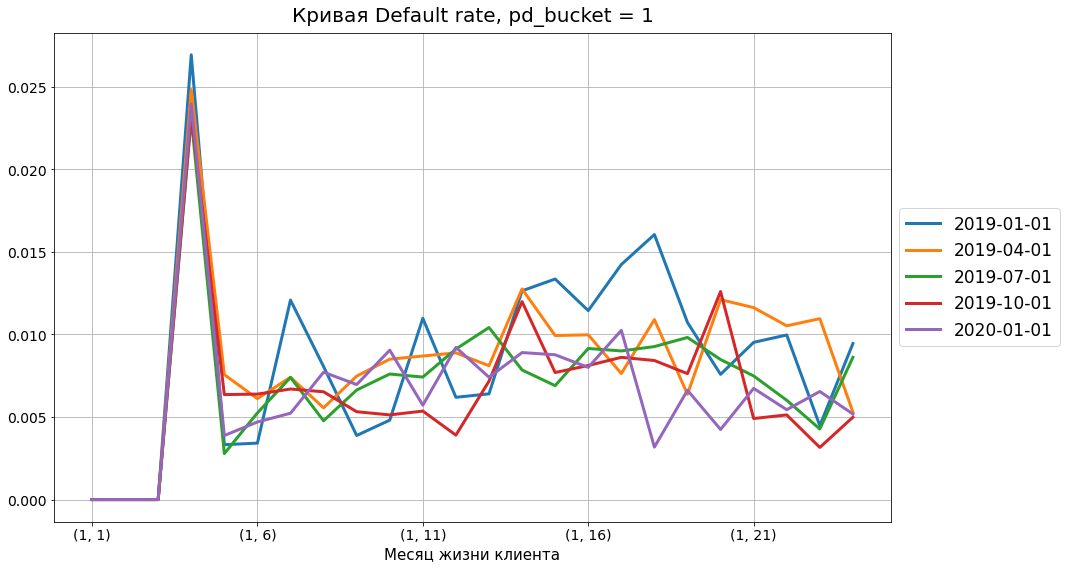

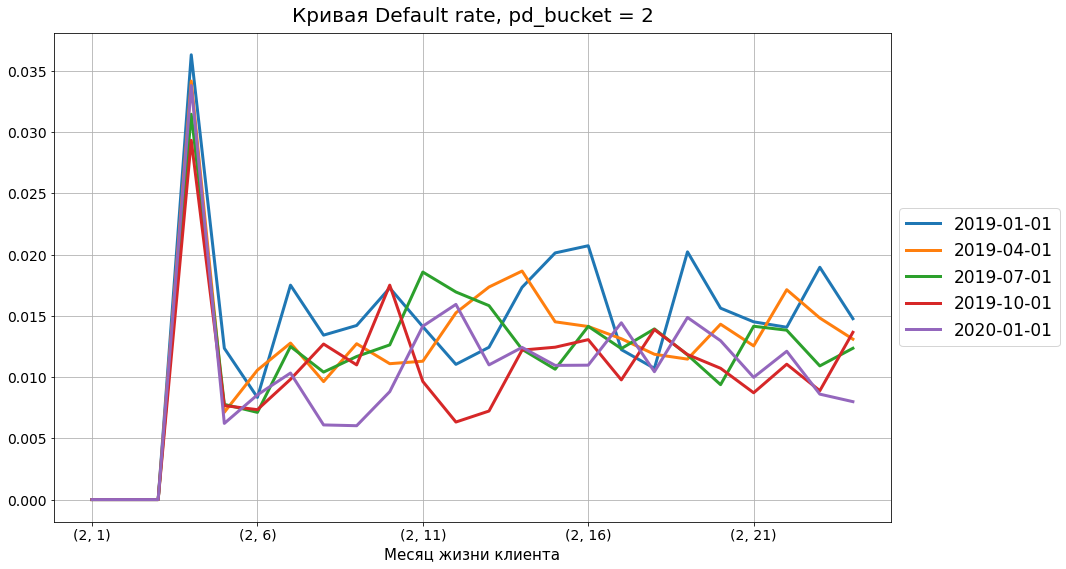

In [ ]:
from ipywidgets import interactive
%matplotlib inline
# Выгружаем таблицу c винтажами

default_rate_data = data_vintages.eval('def_new_flg = def_flg * prev_act_flg', inplace=False)\
    .groupby(["gen_quarter_dt", 'pd_bucket', "statement_num"])\
    .agg({"def_new_flg":np.sum, "prev_act_flg":np.sum, "user_id":np.count_nonzero})\
    .rename(columns = ({"def_new_flg":'def_cnt', "prev_act_flg":'prev_act_cnt', "user_id":"cnt"}))\
    .eval('default_rate = def_cnt / prev_act_cnt', inplace=False)


# Делаем список бакетов

buckets = data_vintages['pd_bucket'].drop_duplicates().sort_values(ascending = True)


# Строим график, который зависит от бакета

def plot_default_rate_by_generation(pd_bucket):
    
    cur_df = default_rate_data.query('pd_bucket == ' + str(pd_bucket))
    (cur_df.unstack('gen_quarter_dt')
            ['default_rate']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая Default rate, pd_bucket = " + str(pd_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

    
# Отображаем его при помощи ipywidget, чтобы получить интерактивность

for i in buckets:
    plot_default_rate_by_generation(i)



Теперь напишем сглаживание. 

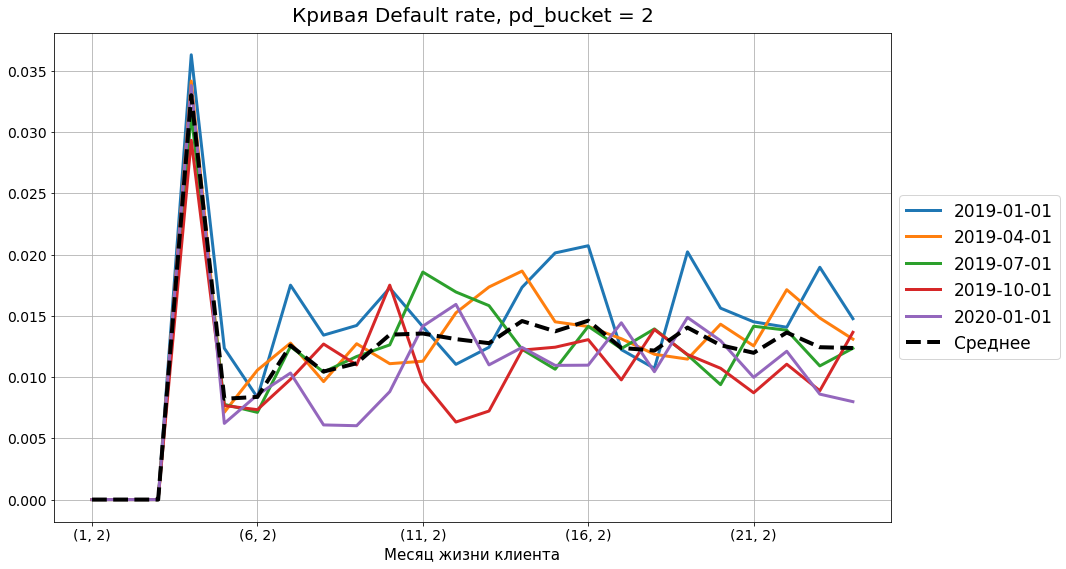

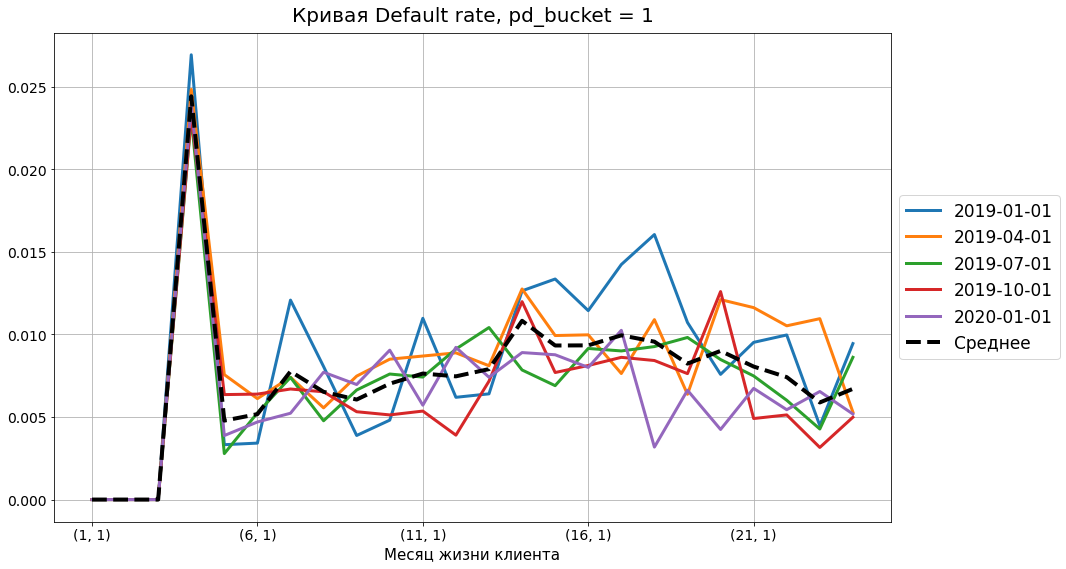

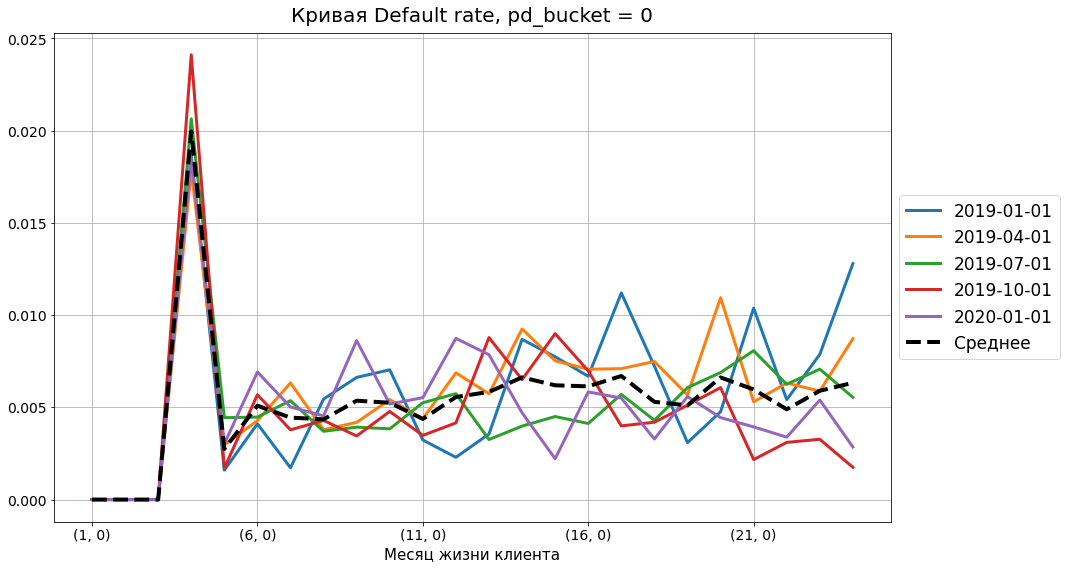

In [ ]:
# Исключаем "странные" поколения
# на графиках не видно аномальных выбросов, поэтому ничего исключать не будем
# на распределении тоже все нормально

# Считаем среднее

default_rate_mean = default_rate_data.groupby(['statement_num', 'pd_bucket'])\
    .agg({'default_rate':np.mean})\
    .rename(columns = {'default_rate':'Среднее'})

buckets = data_vintages['pd_bucket'].drop_duplicates()

# Строим графики винтажей и среднего

def plot_default_rate_mean(pd_bucket):
    vintages_graph = default_rate_data.query('pd_bucket == ' + str(pd_bucket))\
            .unstack('gen_quarter_dt')\
            ['default_rate']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (default_rate_mean.query('pd_bucket == ' + str(pd_bucket))
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title("Кривая Default rate, pd_bucket = " + str(pd_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

for i in buckets:
    plot_default_rate_mean(i)


Линейное приближение 

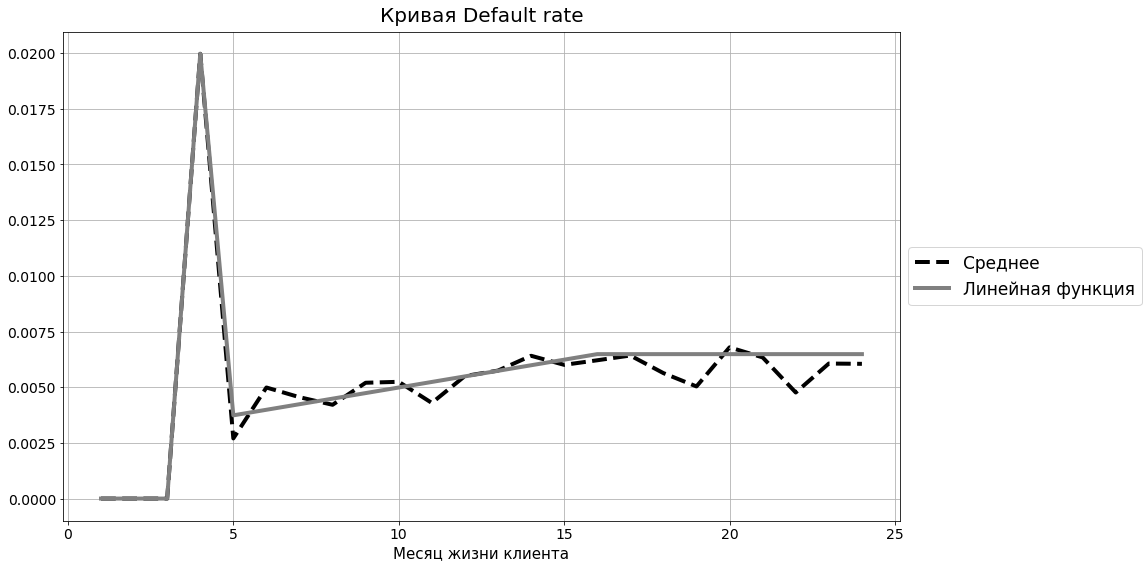

In [ ]:
def linear_approximation(data_vintages, start=1, finish=24):
    df_res = pd.DataFrame(data_vintages)
    df_res['Линейная функция'] = data_vintages['Среднее']                                                # Копируем средние значения
    linear_coeff = np.polyfit(np.arange(start, finish+1),data_vintages.loc[start:finish, 'Среднее'], 1)  # Коэффициенты уравнения прямой
    linear_coeff = np.poly1d(linear_coeff)                                                   # Превращаем коэффициенты в функцию
    df_res.loc[start:finish, 'Линейная функция'] = linear_coeff(np.arange(start, finish+1))   # Записываем приближение
    df_res.loc[finish+1:, 'Линейная функция'] = linear_coeff(finish+1)                        # Продолжаем кривую константой
    return df_res

# Делаем аппроксимацию

df_linear = default_rate_mean.query('pd_bucket == 0').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 5, 15)

# Строим получившийся график

plt.figure(figsize=(15, 9))
df_linear['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_linear['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Default rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Полином

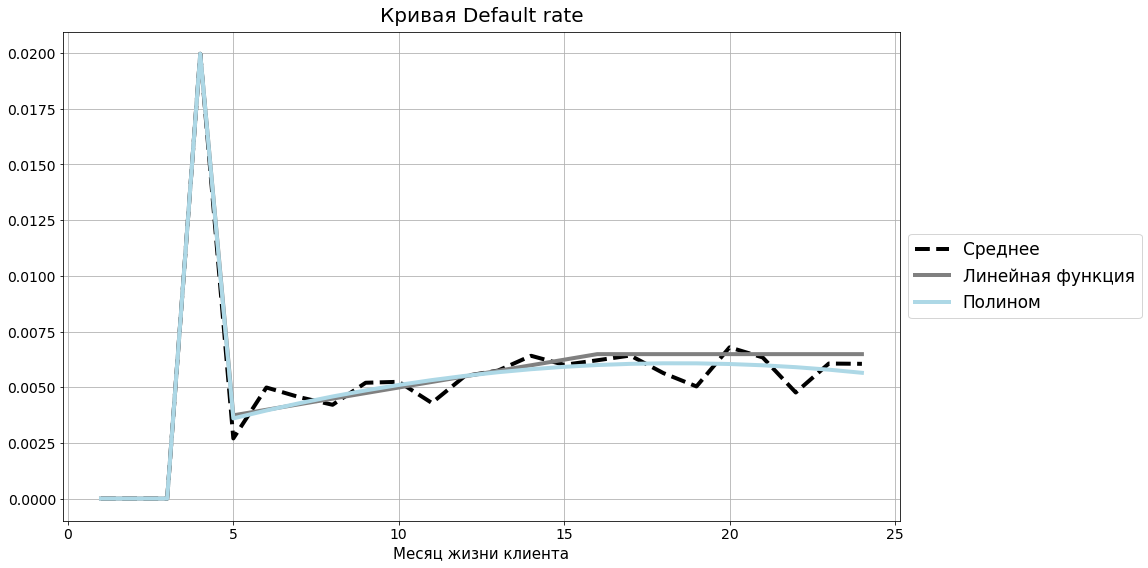

In [ ]:
def polynom_approximation(data_vintages, start=1, finish=20, degree = 1):
    df_res = pd.DataFrame(data_vintages)
    df_res['Полином'] = data_vintages['Среднее']                   
    linear_coeff = np.polyfit(np.arange(start, finish+1),data_vintages.loc[start:finish, 'Среднее'], degree)  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)                                                 
    df_res.loc[start:finish, 'Полином'] = linear_coeff(np.arange(start, finish+1)) 
    df_res.loc[finish+1:, 'Полином'] = linear_coeff(finish+1)                    
    return df_res


# Делаем полиномиальную аппроксимацию
df_polynom = polynom_approximation(df_linear, 5,24,2)

# Строим получившиеся графики вместе
plt.figure(figsize=(15, 9))
df_polynom['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_polynom['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_polynom['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Default rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Попробуем также 3 и 4 степень полинома

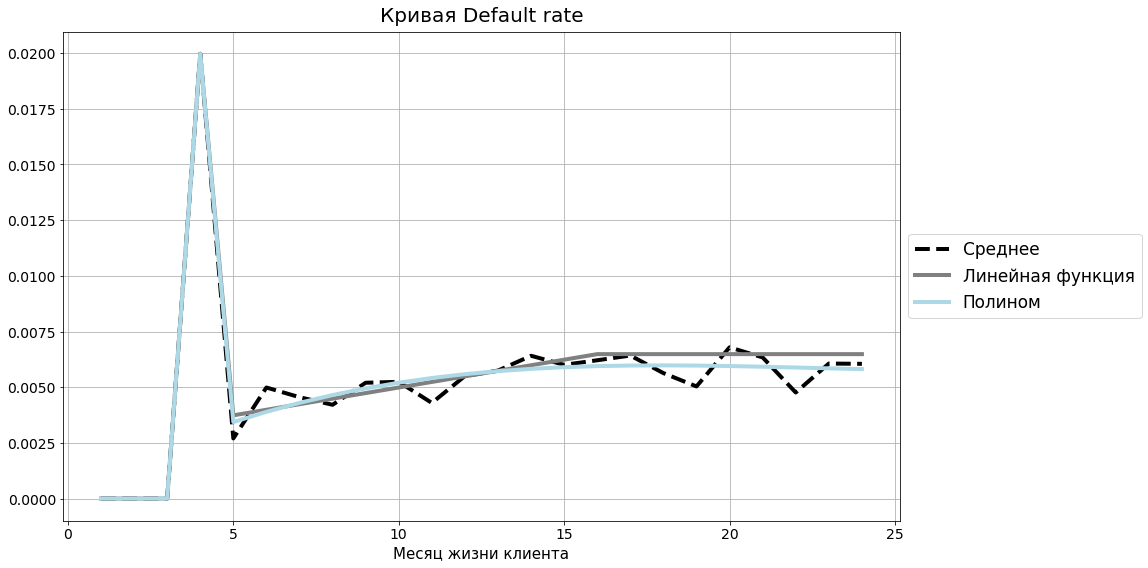

In [ ]:
# Делаем полиномиальную аппроксимацию
df_polynom = polynom_approximation(df_linear, 5,24,3)

# Строим получившиеся графики вместе
plt.figure(figsize=(15, 9))
df_polynom['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_polynom['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_polynom['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Default rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

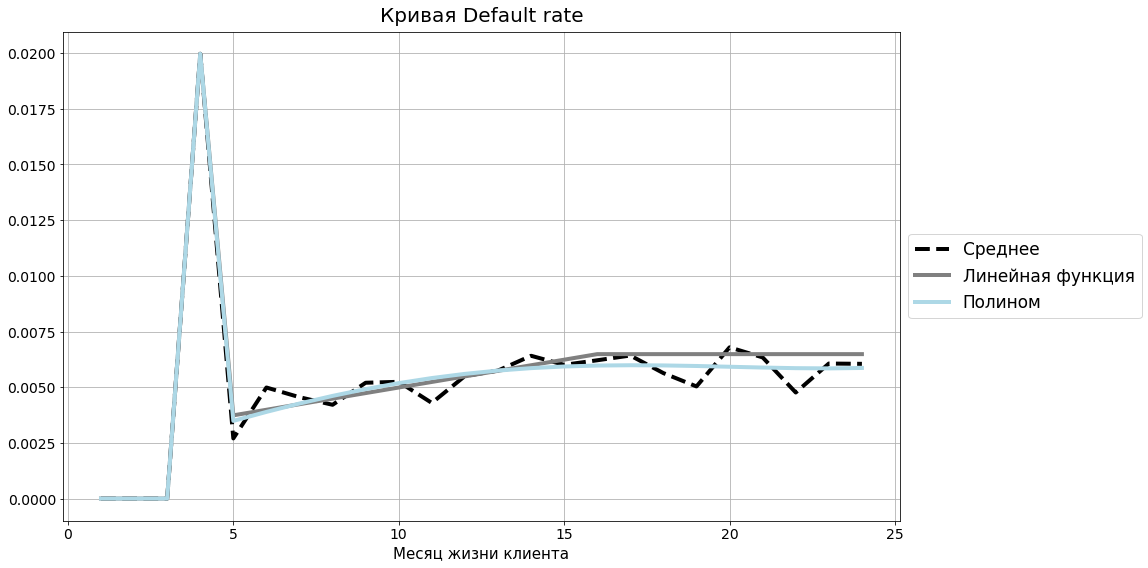

In [ ]:
# Делаем полиномиальную аппроксимацию
df_polynom = polynom_approximation(df_linear, 5,24,4)

# Строим получившиеся графики вместе
plt.figure(figsize=(15, 9))
df_polynom['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_polynom['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_polynom['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Default rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Экпоненциальное

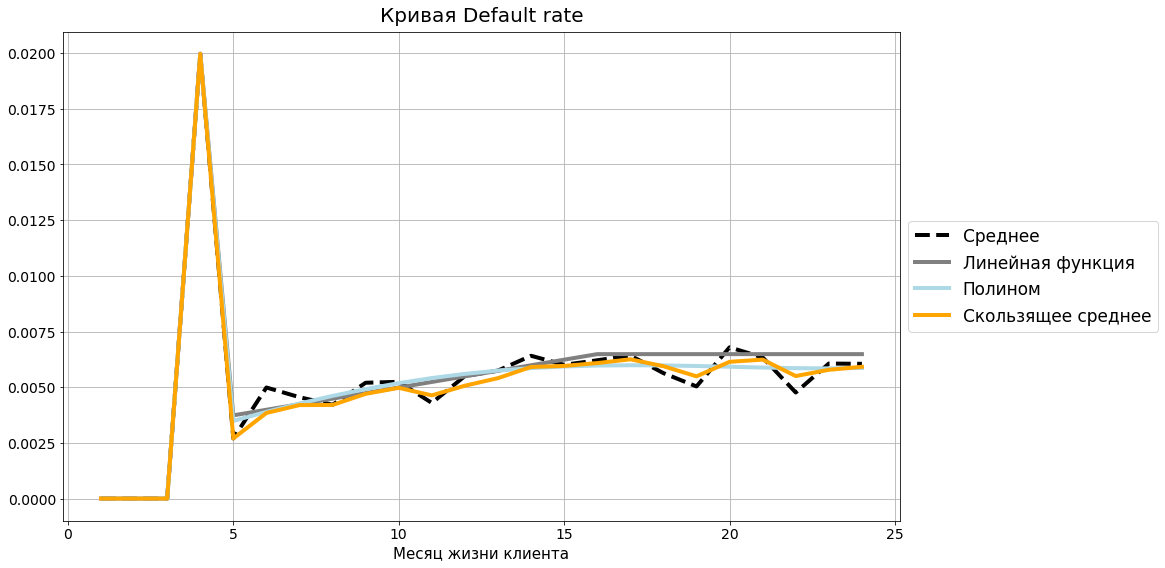

In [ ]:
def exponential_smoothing(data_vintages, start, finish, alpha):
    df_res = pd.DataFrame(data_vintages)
    result = [df_res.loc[i,'Среднее'] for i in np.arange(1,start+1)]                              # Начальные значения копируем
    for n in range(start, len(df_res['Среднее'])): 
        result.append(float(alpha * df_res.loc[n + 1, 'Среднее'] + (1 - alpha) * result[n-1]))    # Делаем сглаживание
    df_res['Скользящее среднее'] = result
    return df_res

# Строим экспоненциальное скользящее среднее с alpha = 0.25
df_smooth = exponential_smoothing(df_polynom, 5,24, 0.5)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Default rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Видим, что экспоненциальное сглаживание приближает среднее лучше всего. 

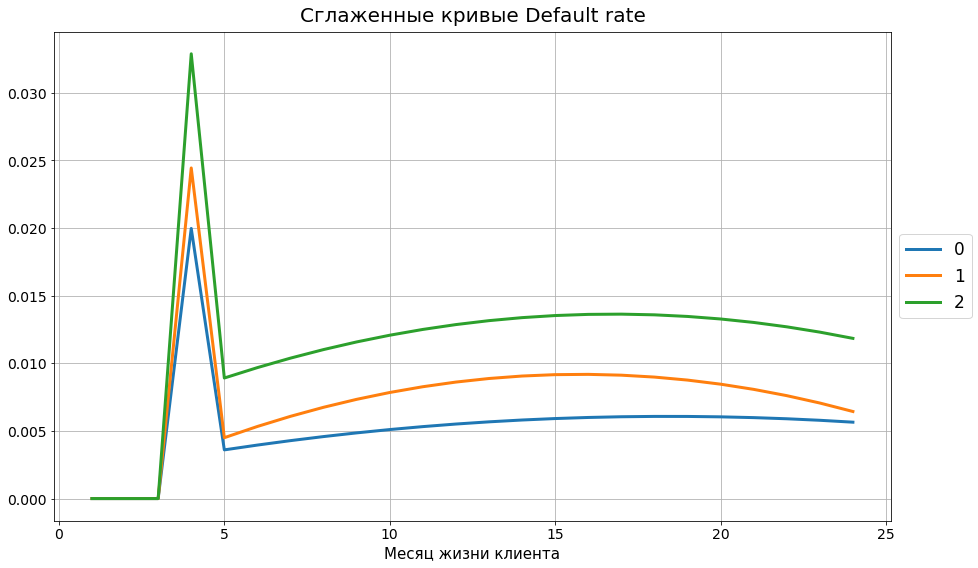

In [ ]:
# Запоминаем набор бакетов и заводим пустой датафрейм под результат

buckets = data_vintages['pd_bucket'].drop_duplicates().sort_values()
df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in buckets:
    df_temp = default_rate_mean.query('pd_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 5,24,2)['Полином']
    
# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые Default rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Теперь DLQ ratio

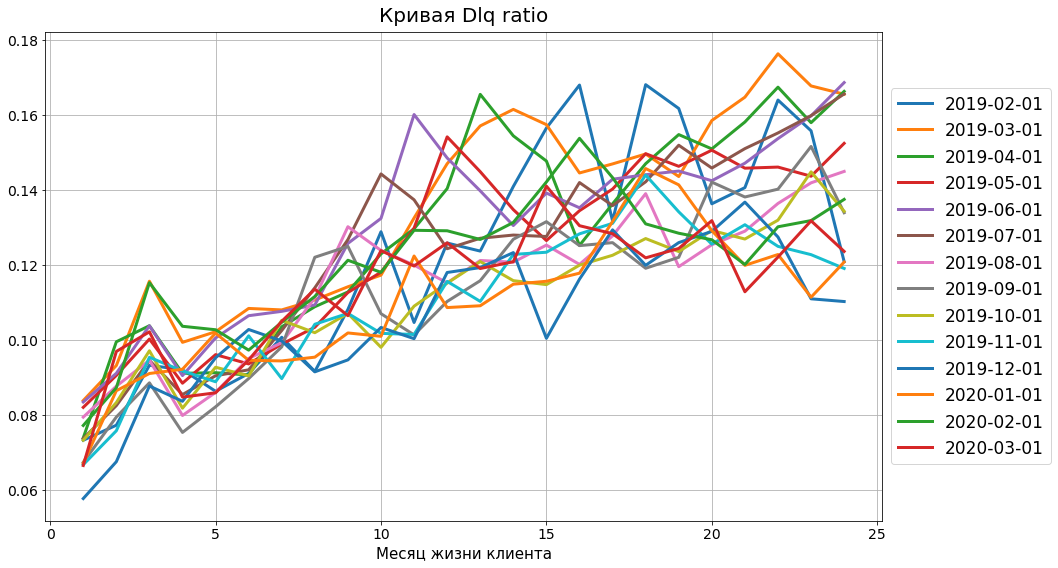

In [ ]:


def plot_dlq_ratio_by_generation(df):
    return (data_vintages.groupby(["gen_month_dt", "statement_num"])
            .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\
            .rename(columns = ({"dlq_flg":'dlq_cnt', "act_flg":'act_cnt', "user_id":"cnt"}))\
            .eval('dlq_ratio = dlq_cnt / act_cnt', inplace=False)\
            .unstack('gen_month_dt')
            ['dlq_ratio']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))               

# Строим график при помощи pyplot
plot_dlq_ratio_by_generation(data_vintages)

# Настраиваем параметры отображения графика
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

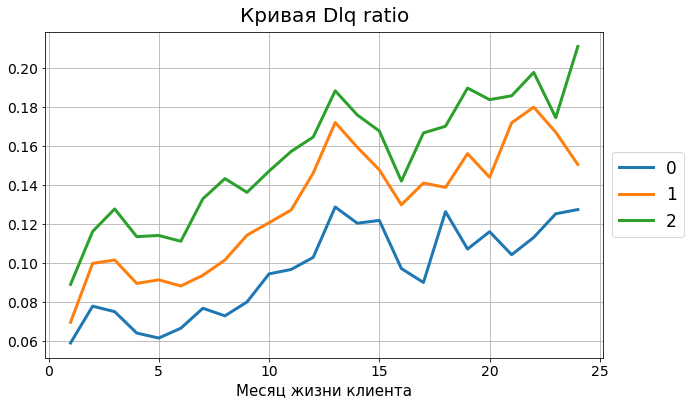

In [ ]:
def plot_dlq_ratio_by_bucket(df, bucket):
    return (data_vintages.query(''' gen_month_dt == '2019-04-01' ''')
            .groupby([bucket, "statement_num"])
            .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\
            .rename(columns = ({"dlq_flg":'dlq_cnt', "act_flg":'act_cnt', "user_id":"cnt"}))\
            .eval('dlq_ratio = dlq_cnt / act_cnt', inplace=False)\
            .unstack(bucket)
            ['dlq_ratio']
            .plot(ax=None, figsize=(10, 6), grid=True, lw = 3))

plot_dlq_ratio_by_bucket(data_vintages, 'pd_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

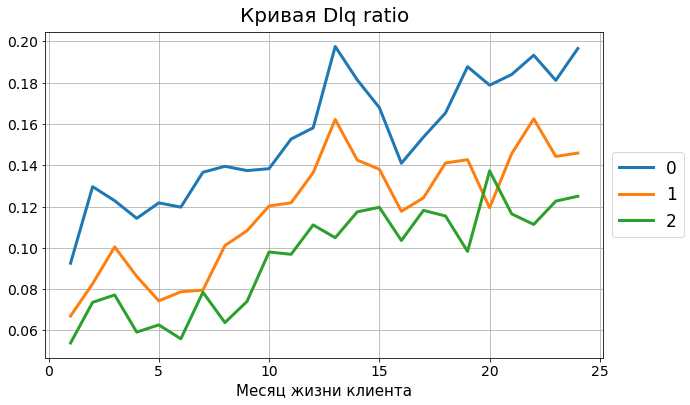

In [ ]:
plot_dlq_ratio_by_bucket(data_vintages, 'x_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Здесь явно видно, что pd делит лучше. 

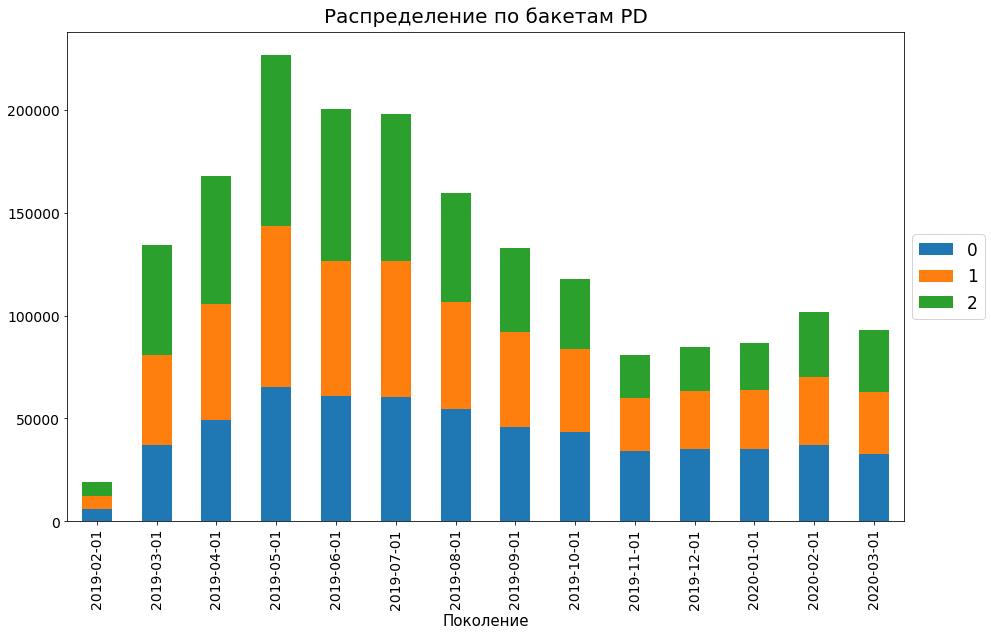

In [ ]:
def plot_distribution(df, bucket):
    return pd.pivot_table(data_vintages, index=[bucket], columns='gen_month_dt',          # делаем сводную таблицу и транспонируем ее
                values="user_id",
                aggfunc=np.count_nonzero, fill_value=0)\
               .T\
               .plot(kind='bar', stacked=True, figsize=(15, 9))                    # Рисуем график распределения столбиками

plot_distribution(data_vintages, 'pd_bucket')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Распределение по бакетам PD", size=20, verticalalignment='bottom')
plt.xlabel("Поколение", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

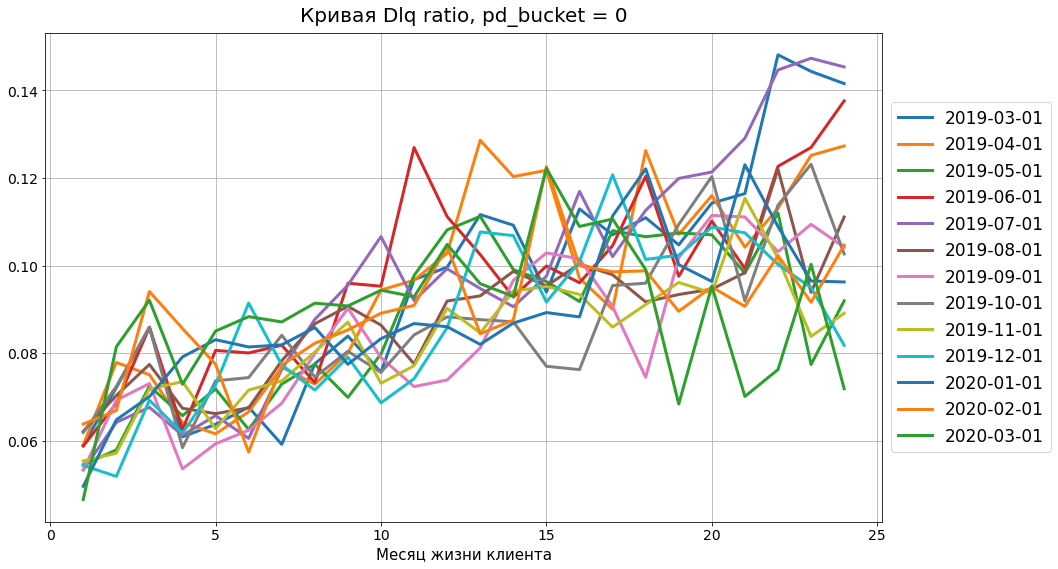

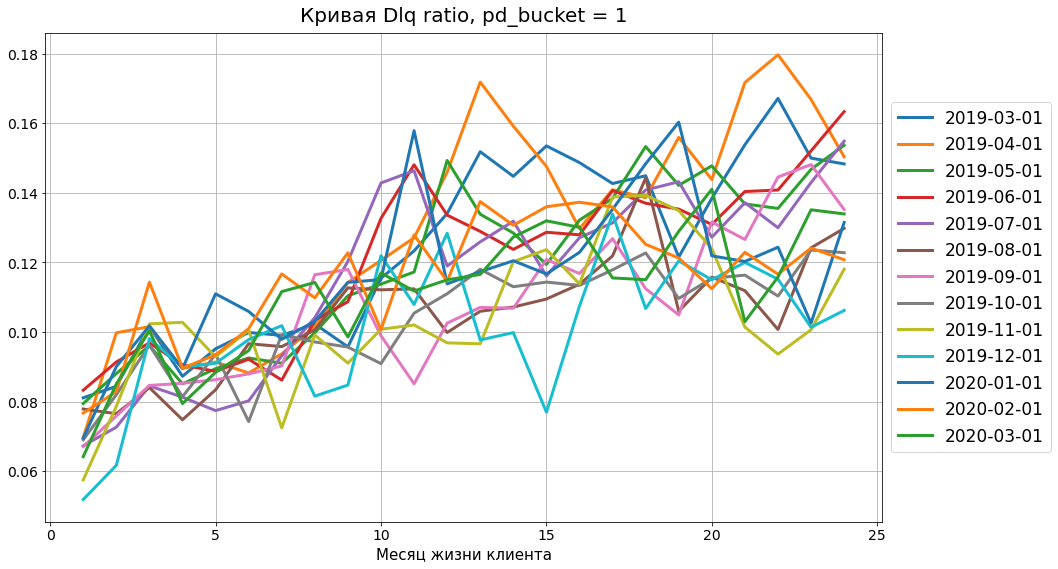

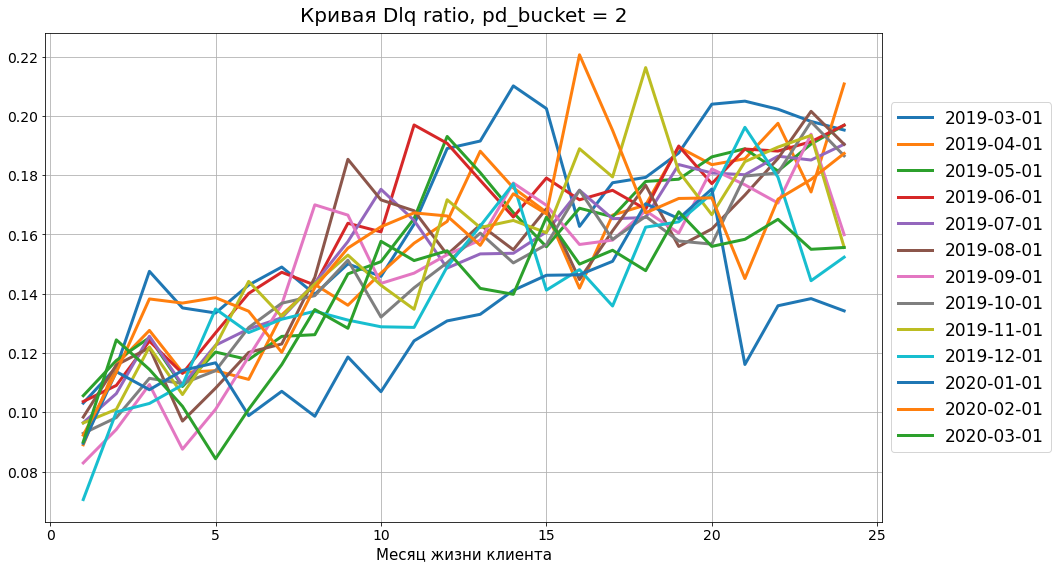

In [ ]:
# Исключаем плохое поколение

exception_query = ''' ~((gen_month_dt == '2019-02-01')) '''
data_vintages.query(exception_query, inplace = True)

# Делаем список бакетов

buckets = data_vintages['pd_bucket'].drop_duplicates().sort_values(ascending = True)


# Строим график, который зависит от бакета

def plot_dlq_ratio_by_generation(data, pd_bucket):
    data_tmp = data.query('''pd_bucket == @pd_bucket''')\
        .groupby(["gen_month_dt", "statement_num"])\
        .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\
        .rename(columns = ({"dlq_flg":'dlq_cnt', "act_flg":'act_cnt', "user_id":"cnt"}))\
        .eval('dlq_ratio = dlq_cnt / act_cnt', inplace=False)\
        .unstack('gen_month_dt')['dlq_ratio']\
        .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая Dlq ratio, pd_bucket = " + str(pd_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)
    return data_tmp

    
for i in buckets:
    plot_dlq_ratio_by_generation(data_vintages, i)